In [1]:
import pandas as pd
import numpy as np
import pymannkendall as mk
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima, ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
GLOBAL_BLUE = "#4285F4"
GLOBAL_RED = "#DB4437"
GLOBAL_YELLOW = "#F4B400"
GLOBAL_GREEN = "#0F9D58"

In [2]:
def test_stationarity(col):
    testresult = ADFTest(alpha=0.05).should_diff(col)
    p, text = testresult[0], testresult[1]
    print('p-value: ' + str(round(p,2)))
    print('Ar reikia diferencijuoti: ' + str(text))
    
def split_dataset(col):
    train = col[col.index <= "2022-02-13"].XRP_price
    test = col[col.index > "2022-02-13"].XRP_price
    print(col.shape, train.shape, test.shape)
    
    return train, test

def plot_decomposition(col, period):
    ts_dicomposition = seasonal_decompose(col, model='additive', period=period)
    trend_estimate = ts_dicomposition.trend
    seasonal_estimate = ts_dicomposition.seasonal
    residual_estimate = ts_dicomposition.resid

    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    # First plot to the Original time series
    axes[0].plot(day.XRP_price, label='Original', color = GLOBAL_BLUE, linewidth = 3) 
    axes[0].legend(loc='upper left');
    # second plot to be for trend
    axes[1].plot(trend_estimate, label='Trend', color = GLOBAL_RED, linewidth = 3)
    axes[1].legend(loc='upper left');
    # third plot to be Seasonality component
    axes[2].plot(seasonal_estimate, label='Seasonality', color = GLOBAL_YELLOW, linewidth = 3)
    axes[2].legend(loc='upper left');
    # last last plot to be Residual component
    axes[3].plot(residual_estimate, label='Residuals', color = GLOBAL_GREEN, linewidth = 3)
    axes[3].legend(loc='upper left');

def plotpredict(model, test):
    forecasts = model.predict(test.shape[0])
    x = np.arange(test.shape[0])
    plt.plot(x, test, c='blue', label = "true")
    plt.plot(x, forecasts, c='green', label = "prediction")
    plt.legend(loc="upper left")
    plt.show()
    
def model_ar(train, valid):
    print("AR:")
    ar = auto_arima(
        train,
        start_p=1, max_p=30,
        start_q=0, max_q=0, 
        d=0,
        seasonal=True,
        trace=False,
        stepwise=True)
    
    plotpredict(ar, valid)

def model_arma(train, valid):
    print("ARMA:")
    arma = auto_arima(
        train,
        start_p=1, max_p=30,
        start_q=1, max_q=30,
        d=0,           
        seasonal=True,  
        trace=False,
        stepwise=True)
    
    plotpredict(arma, valid)
        
def model_arima(train, valid):
    print("ARIMA:")
    arima = auto_arima(
        train, 
        start_p=1, max_p=30,
        start_q=1, max_q=30,
        d=None,
        seasonal=True,
        trace=False,
        stepwise=True)
    
    plotpredict(arima,valid)

# Day

In [3]:
day = pd.read_csv("data/full_day.csv", parse_dates=['time'])[['time', 'XRP_price']].set_index('time')
test_stationarity(day.XRP_price)

p-value: 0.39
Ar reikia diferencijuoti: True


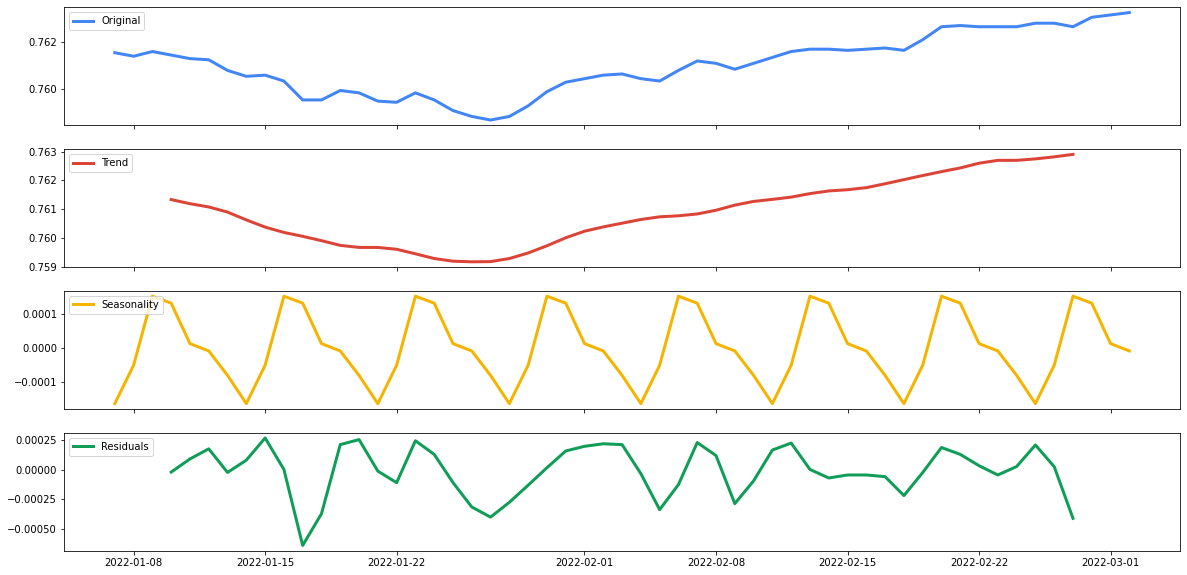

In [4]:
plot_decomposition(day, 7)

In [5]:
day_train, day_test = split_dataset(day)

(55, 1) (38,) (17,)


AR:


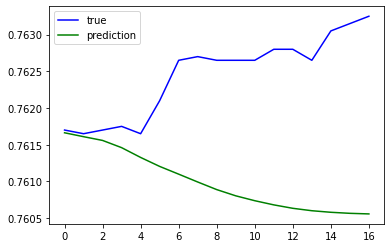

ARMA:


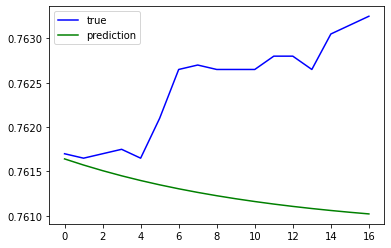

ARIMA:


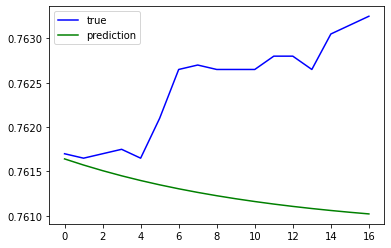

In [6]:
model_ar(day_train, day_test)
model_arma(day_train, day_test)
model_arima(day_train, day_test)

### Mann-Kendell Trend Test (day)

#### https://www.statology.org/mann-kendall-test-python/

In [7]:
mk.original_test(day_train)
# trend is not statistically significant

Mann_Kendall_Test(trend='no trend', h=False, p=0.7819555436291108, z=0.27677152952723505, Tau=0.032716927453769556, s=23.0, var_s=6318.333333333333, slope=2.8571428571425426e-06, intercept=0.7604471428571429)

# Hour

In [8]:
hour = pd.read_csv("data/full_hour.csv", parse_dates=['time'])[['time', 'XRP_price']].set_index('time')
test_stationarity(hour.XRP_price)

p-value: 0.76
Ar reikia diferencijuoti: True


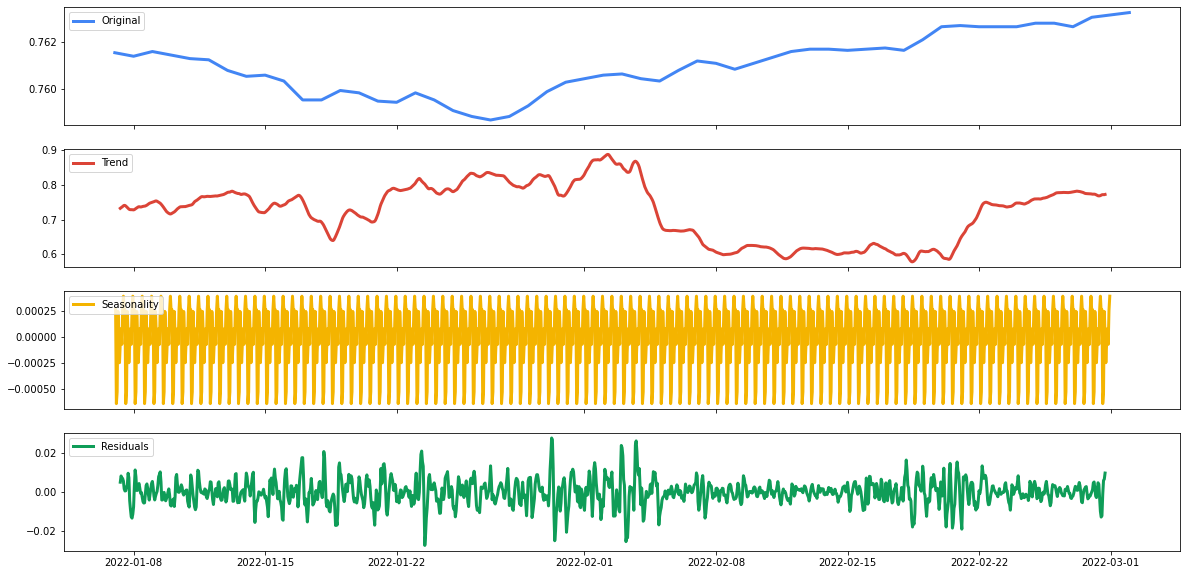

In [9]:
plot_decomposition(hour, 12)

In [10]:
hour_train, hour_test = split_dataset(hour)

(1271, 1) (888,) (383,)


AR:


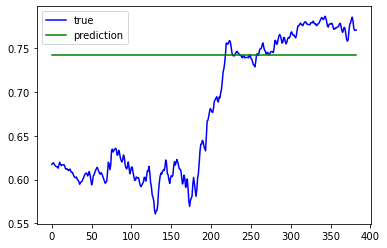

ARMA:


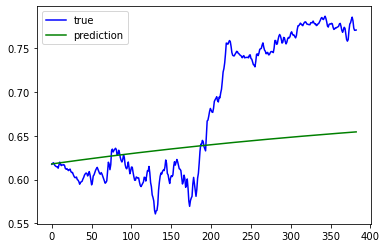

ARIMA:


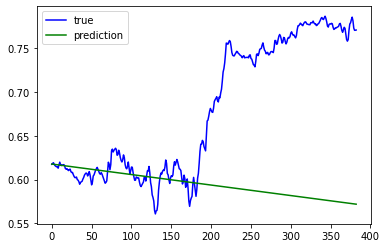

In [11]:
model_ar(hour_train, hour_test)
model_arma(hour_train, hour_test)
model_arima(hour_train, hour_test)

### Mann-Kendell Trend Test (hour)

In [13]:
mk.original_test(hour_train)
# rado statistiškai reikšmingą trendą

Mann_Kendall_Test(trend='decreasing', h=True, p=0.007990748131446512, z=-2.6524604813541774, Tau=-0.05945996729536752, s=-23417.0, var_s=77934109.0, slope=-6.0510540814230836e-05, intercept=0.7821864248511113)

# Minute

In [15]:
minute = pd.read_csv("data/full_minute.csv", parse_dates=['time'])[['time', 'XRP_price']].set_index('time')
test_stationarity(minute.XRP_price)

p-value: 0.75
Ar reikia diferencijuoti: True


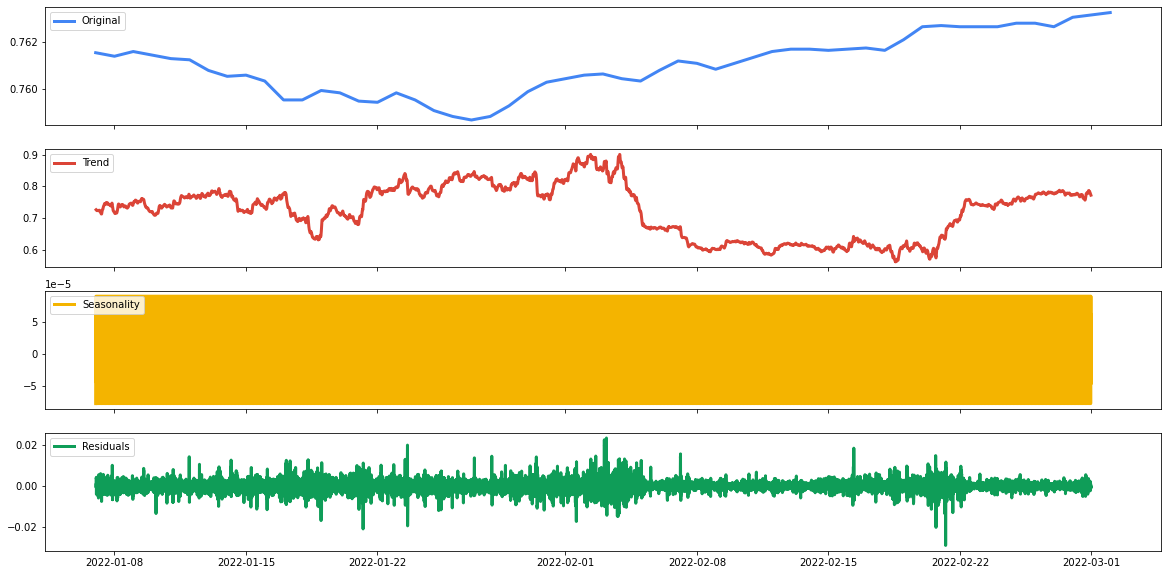

In [16]:
plot_decomposition(minute, 60)

In [17]:
minute_train, minute_test = split_dataset(minute)

(76312, 1) (53280,) (23032,)


AR:


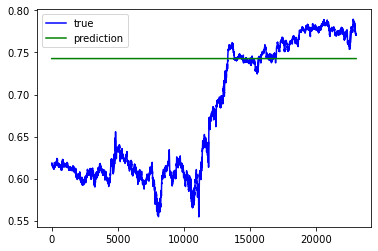

ARMA:


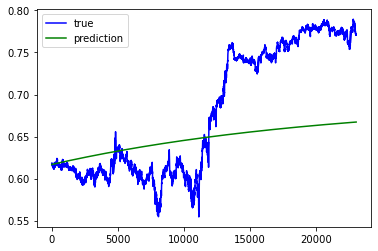

ARIMA:


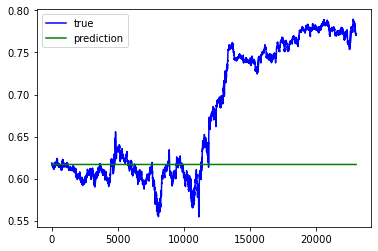

In [18]:
model_ar(minute_train, minute_test)
model_arma(minute_train, minute_test)
model_arima(minute_train, minute_test)

### Mann-Kendell Trend Test (hour)

### Conclusions

1. All time series are not stationary
2. Autoregressive models are not a good fit for ripple price